In [1]:
# Before running this, add lang-seg folder to your python path
from LoadLSeg import *
import torchvision.transforms as transforms
from PIL import Image
from test_lseg_zs import *

/home/fyp/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Namespace(model='encnet', backbone='clip_vitl16_384', dataset='fss', workers=16, base_size=520, crop_size=480, train_split='train', aux=False, se_loss=False, se_weight=0.2, batch_size=16, test_batch_size=16, no_cuda=False, seed=1, weights='/home/fyp/lang-seg/checkpoints/demo_e200.ckpt', eval=False, acc_bn=False, test_val=False, no_val=False, module='clipseg_DPT_test_v2', scale_inv=False, widehead=True, widehead_hr=False, ignore_index=255, jobname='default', strict=True, use_pretrained='True', arch_option=0, nshot=0, fold=0, nworker=0, bsz=1, benchmark='pascal', datapath='data/Datasets_HSN', activation='relu', cuda=True)


/home/fyp/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/migration.py:208: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
Lightning automatically upgraded your loaded checkpoint from v1.3.5 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint checkpoints/demo_e200.ckpt`
/home/fyp/lang-seg/modules/lsegmentation_module_zs.py:50: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = amp.GradScaler(enabled=self.enabled)

:=========== Few-shot Seg. with HSNet ===========
|             datapath: data/Datasets_HSN       
|       

use norm: [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
['ac_wall', 'acorn', 'adhensive_tape', 'adidas_logo1', 'adidas_logo2', 'afghan_hound', 'african_elephant', 'african_grey', 'agama', 'air_strip', 'aircraft_carrier', 'airedale', 'airship', 'almond', 'ambulance', 'american_staffordshire', 'anemone_fish', 'angora', 'apple', 'armour', 'ashtray', 'assult_rifle', 'aubergine', 'avocado', 'baboon', 'backpack', 'bagel', 'balance_weight', 'bald_eagle', 'ballpoint', 'banana', 'band-aid', 'banded_gecko', 'barometer', 'baseball_bat', 'baseball_player', 'basketball', 'bassoon', 'bathtub', 'battery', 'beacon', 'beaker', 'beam_bridge', 'bear', 'beaver', 'bedlington_terrier', 'bee_house', 'besom', 'birdhouse', 'bison', 'black_grouse', 'black_stork', 'black_swan', 'blossom_card', 'boa_constrictor', 'bolotie', 'bomb', 'border_terrier', 'boston_bull', 'bottle_cap', 'bouzouki', 'box_turtle', 'bra', 'bracelet', 'bradypod', 'brain_coral', 'brambling', 'brasscica', 'brick', 'brick_card', 'brick_tea', 'briefcase', 'br

In [2]:
image = Image.open("/home/fyp/Pictures/TestSeg/office1.jpg")
print(type(image))
print(image.size)

<class 'PIL.JpegImagePlugin.JpegImageFile'>
(540, 360)


In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize(480),           # Resize the shorter side to 480 while maintaining aspect ratio
    transforms.CenterCrop((480, 480)),  # Crop the center to 480x480
    transforms.ToTensor()            # Convert to tensor
])

# Apply transformations
image_tensor = transform(image)
image_tensor.shape

torch.Size([3, 480, 480])

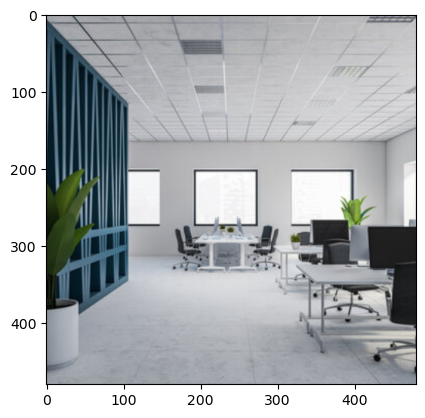

In [4]:
import matplotlib.pyplot as plt
plt_image = image_tensor.permute(1, 2, 0).cpu().numpy()
plt.imshow(plt_image)

In [5]:
torch.cuda.empty_cache()
with torch.no_grad():
    feat = model(image_tensor.unsqueeze(0).cuda())
feat.shape

torch.Size([480, 480, 512])

###############################################
searching for: window
###############################################
max value at (coordinate in pixel): row 271.0 col 232.0
max value at (coordinate %): 0.56 0.48


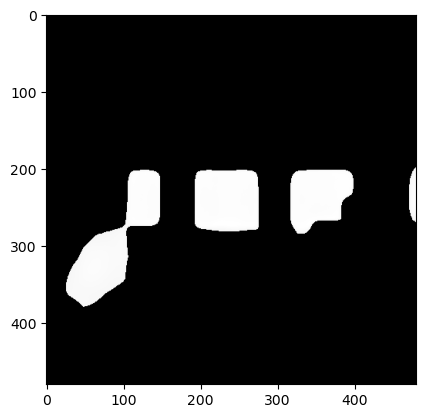

In [6]:
search = "window"
threshold = 0.96
text_feat1 = model.encode_text(search)
sim_image = feat.half() @ text_feat1.t()
sim_image[sim_image < sim_image.max()*threshold] = 0
display_img2 = sim_image.detach().cpu().numpy()
plt.imshow(display_img2, cmap='gray', vmin=display_img2.min(), vmax=display_img2.max())
# coordinates of the maximum value in the similarity image
print("###############################################")
print(f"searching for: {search}")
print("###############################################")
x, y = float((sim_image.argmax() // sim_image.shape[1]).detach().cpu()), float((sim_image.argmax() % sim_image.shape[1]).detach().cpu())
print("max value at (coordinate in pixel):", f"row {x}", f"col {y}")
print("max value at (coordinate %):", round(x/480,2), round(y/480, 2))

In [7]:
feat.shape

torch.Size([480, 480, 512])

(230400, 1)


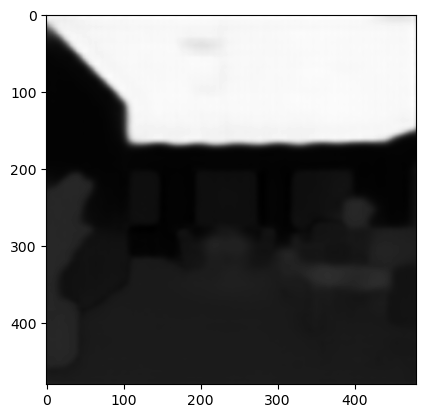

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)

# squeeze first two dimension of feat 
feat_map = feat.flatten(start_dim=0, end_dim=1).detach().cpu().numpy()

# apply pca to each feature vector of feat_map
pca_feat_map = pca.fit_transform(feat_map)
print(pca_feat_map.shape)
feat_image = pca_feat_map.reshape(480, 480, -1)
plt.imshow(feat_image, cmap='gray', vmin=feat_image.min(), vmax=feat_image.max())

In [10]:
feat_image[300, 300]

array([-0.19654252], dtype=float32)

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


feature_map = feat.detach().cpu().numpy()
# Assume feature_map is your per-pixel feature map with shape (H, W, D)
H, W, D = feature_map.shape
# Flatten the feature map to (H*W, D)
features = feature_map.reshape(-1, D)

# Choose the number of clusters
n_clusters = 10

# Apply K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
labels = kmeans.fit_predict(features)
print(labels.shape)

# Reshape the labels back to the original image shape
clustered_image = labels.reshape(H, W)

# Visualize the clustered image
plt.imshow(clustered_image, cmap='viridis')
plt.title('Clustered Image')
plt.show()

In [ ]:
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

# Assume feature_map is your per-pixel feature map with shape (H, W, D)
feature_map = feat.detach().cpu().numpy()
H, W, D = feature_map.shape

# Flatten the feature map to (H*W, D)
features = feature_map.reshape(-1, D)

# Apply DBSCAN clustering
# Choose appropriate eps and min_samples based on your data
eps = 0.5
min_samples = 10
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
labels = dbscan.fit_predict(features)

# Reshape the labels back to the original image shape
clustered_image = labels.reshape(H, W)

# Visualize the clustered image
plt.imshow(clustered_image, cmap='viridis')
plt.title('Clustered Image with DBSCAN')
plt.show()

In [ ]:
import numpy as np
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt

feature_map = feat.detach().cpu().numpy()
# Assume feature_map is your per-pixel feature map with shape (H, W, D)
H, W, D = feature_map.shape

# Flatten the feature map to (H*W, D)
features = feature_map.reshape(-1, D)

# Apply Spectral Clustering
# Choose the number of clusters
n_clusters = 5
spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_init=10, assign_labels='kmeans', random_state=0)
labels = spectral.fit_predict(features)

# Reshape the labels back to the original image shape
clustered_image = labels.reshape(H, W)

# Visualize the clustered image
plt.imshow(clustered_image, cmap='viridis')
plt.title('Clustered Image with Spectral Clustering')
plt.show()

In [ ]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

feature_map = feat.detach().cpu().numpy()
# Assume feature_map is your per-pixel feature map with shape (H, W, D)
H, W, D = feature_map.shape

# Flatten the feature map to (H*W, D)
features = feature_map.reshape(-1, D)

# Apply Agglomerative Clustering
# Choose the number of clusters
n_clusters = 10
agglomerative = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
labels = agglomerative.fit_predict(features)

# Reshape the labels back to the original image shape
clustered_image = labels.reshape(H, W)

# Visualize the clustered image
plt.imshow(clustered_image, cmap='viridis')
plt.title('Clustered Image with Agglomerative Clustering')
plt.show()